In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [2]:

import torch 
print(torch.__version__)
import torchvision

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import argparse
import os
import os.path as osp
import torch.nn.functional as F
import torch.nn as nn

# import matplotlib
# %matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import tqdm
from dataloaders import fundus_dataloader as DL
from torch.utils.data import DataLoader
from dataloaders import custom_transforms as tr
from torchvision import transforms
# from scipy.misc import imsave
from matplotlib.pyplot import imsave
from utils.Utils import *
from utils.metrics import *
from datetime import datetime
import pytz
import networks.deeplabv3 as netd
import networks.deeplabv3_eval as netd_eval
import cv2
import torch.backends.cudnn as cudnn
import random
from tensorboardX import SummaryWriter

from sklearn.manifold import TSNE
        

2.4.0+cu118


In [3]:
from torchvision.utils import make_grid
import matplotlib.patches as mpatches
%matplotlib inline
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import masks_to_boxes
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [4]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
def show_mask(mask, ax, random_color=False, gt_color=False, alpha=0.6):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif gt_color:
        color = np.array([170/255, 255/255, 0/255, alpha])
    else:
        color = np.array([30/255, 144/255, 255/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


Creating DPL's initial model and dataloader

In [59]:
base_args = {
    'data_dir': '../datasets/Fundus',
    'dataset': 'Domain2',
    # 'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/base.pth.tar',
    # 'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/logs/Domain2/20240717_135233.062115/checkpoint_200.pth.tar',
    'out_stride': 16,
    'sync_bn': True,
    'freeze_bn': False
}

args_dpl = {
    **base_args,
    'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/logs/train_target/D2_checkpoint_1.pth.tar',
}

args_noada = {
    **base_args,
    # 'dataset': 'Domain2',
    'model_file': '/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/base.pth.tar',
}

data_dir = base_args['data_dir']
dataset = base_args['dataset']

composed_transforms_train = transforms.Compose([
    tr.Resize(512),
    tr.add_salt_pepper_noise(),
    tr.adjust_light(),
    tr.eraser(),
    tr.Normalize_tf(),
    tr.ToTensor()
])
composed_transforms_test = transforms.Compose([
    tr.Resize(512),
    tr.Normalize_tf(),
    tr.ToTensor()
])

print("Creating dataloader")
print("Train batch size was 8 and changed to 1")
db_train = DL.FundusSegmentation(base_dir=data_dir, dataset=dataset, split='train/ROIs', transform=composed_transforms_test)
train_loader = DataLoader(db_train, batch_size=1, shuffle=False, num_workers=1)

db_test = DL.FundusSegmentation(base_dir=data_dir, dataset=dataset, split='test/ROIs', transform=composed_transforms_test)
test_loader = DataLoader(db_test, batch_size=1, shuffle=False, 
                        num_workers=1
)
print("Dataloader created")

def create_model_from_args(args : dict):
    model_file = args['model_file']
    out_stride = args['out_stride']
    sync_bn = args['sync_bn']
    freeze_bn = args['freeze_bn']

    print("Move model to cuda")
    model = netd_eval.DeepLab(num_classes=2, backbone='mobilenet', output_stride=out_stride, sync_bn=sync_bn, freeze_bn=freeze_bn).cuda()
    print("Model moved to cuda")
    checkpoint = torch.load(model_file)

    pretrained_dict = checkpoint['model_state_dict']
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model.state_dict()}

    print("Loading model")
    model.load_state_dict(pretrained_dict)
    print("Model loaded")
    # pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # model.load_state_dict(pretrained_dict)
    
    return model

model = create_model_from_args(args_dpl)
model_noada = create_model_from_args(args_noada)

if args_dpl['dataset']=="Domain2":
    # npfilename = './generate_pseudo/pseudolabel_D2.npz'
    npfilename = "./results/prototype/pseudolabel_D2_original_2408.npz"
elif args_dpl['dataset']=="Domain1":
    npfilename = './generate_pseudo/pseudolabel_D1.npz'

npdata = np.load(npfilename, allow_pickle=True)
pseudo_label_dic = npdata['arr_0'].item()
uncertain_dic = npdata['arr_1'].item()
proto_pseudo_dic = npdata['arr_2'].item()

model = model_noada

print(npfilename)


Creating dataloader
Train batch size was 8 and changed to 1
../datasets/Fundus/Domain2/train/ROIs/image
Number of images in train/ROIs: 99
../datasets/Fundus/Domain2/test/ROIs/image
Number of images in test/ROIs: 60
Dataloader created
Move model to cuda
Model moved to cuda


/tmp/ipykernel_432816/906653014.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file)


Loading model
Model loaded
Move model to cuda
Model moved to cuda
Loading model
Model loaded
./results/prototype/pseudolabel_D2_original_2408.npz


In [7]:
from torchvision.utils import make_grid
import matplotlib.patches as mpatches


model = model.train()

def add_mask(img,mask):  
    label2color = {0:np.array([0,0,0]),1:np.array([224/255,255/255,255/255])
                #    ,2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])
                   }
    
    
    # pred_mask = np.zeros_like(img).astype(np.uint8)
    pred_mask = np.zeros_like(img).astype(np.float32)
    # print(pred_mask.shape)
    # print(mask.shape)
    for l,color in label2color.items():
        # print(pred_mask[:, mask==l].shape)
        # print((mask==l).shape)
        pred_mask[:, mask==l] = np.expand_dims(color,1)
    img_pred = cv2.addWeighted(img,0.5,pred_mask,0.5,0,0)
    return img_pred

def add_mask_outline(img, mask, gt):
    label2color = {0:np.array([0,0,0]),1:np.array([224/255,255/255,255/255])
                #    ,2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])
    }
    mask = mask.astype(np.uint8)
    gt = gt.astype(np.uint8)
    img = (img * 255).astype(np.uint8).copy()
    
    colors = [(3, 94, 252), (3, 252, 32)]
    masks = [mask, gt]
    
    for color, mask in zip(colors, masks):
        cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(img, [c], -1, color, thickness=2)
    return img


def add_heatmap(img,entropy_map):

    entropy_map = (entropy_map - entropy_map.min())/(entropy_map.max()-entropy_map.min())
    entropy_map = (entropy_map * 255).astype(np.uint8)
    print(entropy_map.dtype)
    print(img.dtype)
    img = (img * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(entropy_map[0],cv2.COLORMAP_JET)
    img_uncertainty = cv2.addWeighted(img,0.7,heatmap[:,:,::-1],0.3,0,0)
    return img_uncertainty

def create_visuals(inspect_dict, data, target, img_name, prediction, target_numpy, cup_dice, disc_dice, entropy_map):
    classes = [0,1]
    classes_names = ['cup', 'disc']
    dice_scores = [cup_dice, disc_dice]
    print(f"IMG: {img_name} CUP_DICE: {cup_dice} DISC_DICE: {disc_dice[0]}")
    show_images = []
    view_img = make_grid(
                        data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
    show_images.append(view_img.transpose(1,2,0))
    for name,class_id,dice_score in zip(classes_names, classes, dice_scores):
                # print(data.detach().cpu().numpy()[0].shape)
                # print(f"max data {data.max()} min data {data.min()}")
                
                # print(view_img.dtype)
        gt_mask = target_numpy.detach().cpu().numpy()[:,class_id, ...].transpose(1, 2, 0)
        pred_mask = prediction.detach().cpu().numpy()[:,class_id, ...].transpose(1, 2, 0)
                # print(view_img.shape)
                # print(gt_mask.shape)                
        masked_im = add_mask_outline(view_img.transpose(1,2,0), gt_mask[:,:,0], pred_mask[:,:,0])
                # masked_pred = add_mask_outline(view_img.transpose(1,2,0), pred_mask[:,:,0])
        show_images.append(masked_im)
    
    print(f"View img shape: {view_img.shape}")
    print(f"Entropy map shape: {entropy_map.shape}")
    entropy_img = add_heatmap(view_img.transpose(1,2,0), entropy_map.detach().cpu().numpy())
    
    fig,axes = plt.subplots(1,4,figsize=(22,6))
            
    fig.suptitle(f"Image: {img_name[0]} | {classes_names[0]} dice: {round(cup_dice[0], 4) * 100} | {classes_names[1]} dice: {round(disc_dice[0], 4) * 100}")
    green_patch = mpatches.Patch(color='green', label='Prediction')
    blue_patch = mpatches.Patch(color='blue', label='Ground Truth')
    fig.legend(handles=[green_patch, blue_patch])
            
    axes[0].title.set_text("Original Image")
    axes[0].imshow(view_img.transpose(1,2,0))
    axes[1].title.set_text("Cup")
    axes[1].imshow(show_images[1])
    axes[2].imshow(prediction.detach().cpu().numpy()[:,0, ...].transpose(1, 2, 0))
    axes[2].title.set_text("Disc")
    axes[2].imshow(show_images[2])
    axes[3].title.set_text("Entropy")
    axes[3].imshow(entropy_img)

    inspect_dict[img_name[0]] = (data, target, img_name)
    plt.show()
    

Create SAM initial model 

In [8]:
import sys
sys.path.append("./segment-anything")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/users/scratch/baryaacovi-2024-06-01/projects/SFDA-DPL/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.l

## Example image

In [9]:
truck_image = cv2.imread('./segment-anything/notebooks/images/truck.jpg')
truck_image = cv2.cvtColor(truck_image, cv2.COLOR_BGR2RGB)

In [10]:
for idx, sample in enumerate(test_loader):
    data, target, img_name = sample['image'], sample['map'], sample['img_name']
    break

In [11]:
plt.figure(figsize=(10,10))
view_img = make_grid(
                    data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
view_img = view_img.transpose(1,2,0)
image = view_img
print(image.shape)
print(type(image))
# plt.imshow(view_img)
# plt.axis('on')
# plt.show()

image = view_img

(512, 512, 3)
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

In [12]:
view_img = make_grid(
                    data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
view_img = view_img.transpose(1,2,0)
predictor.set_image(image)

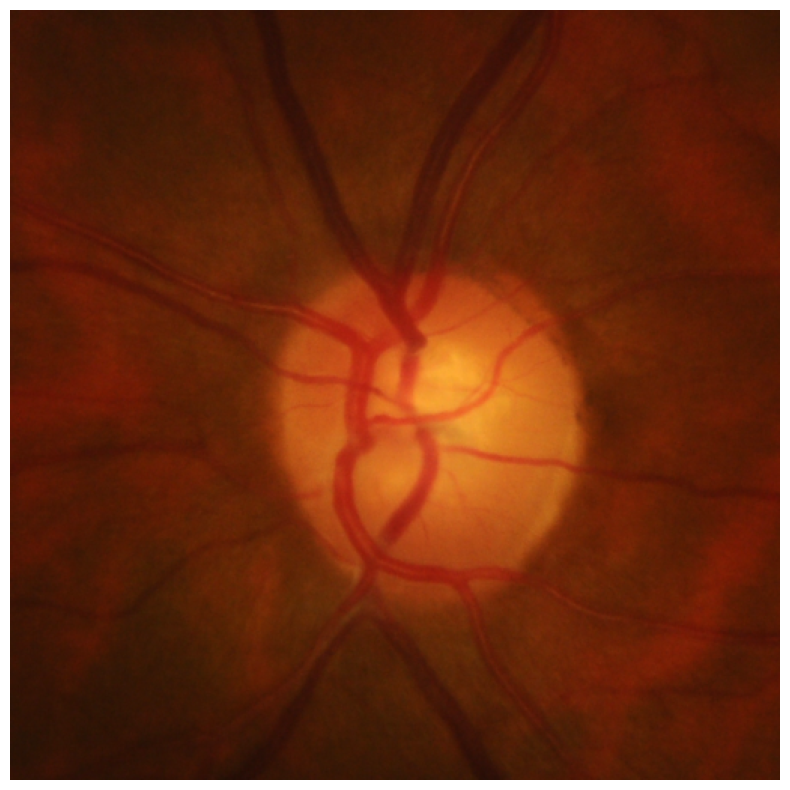

In [13]:
input_box = np.array([425, 600, 700, 875])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

Get pseudo

In [14]:
print(pseudo_label_dic[list(pseudo_label_dic.keys())[0]].shape)
print(list(pseudo_label_dic.keys()))
print(type(pseudo_label_dic))

(2, 512, 512)
['N-87-L.png', 'N-58-R.png', 'N-70-R.png', 'G-17-L.png', 'S-18-L.png', 'S-12-L.png', 'N-65-L.png', 'S-23-L.png', 'N-81-L.png', 'N-55-L.png', 'S-20-L.png', 'G-34-L.png', 'N-6-R.png', 'G-38-L.png', 'G-7-L.png', 'N-73-R.png', 'N-10-R.png', 'S-21-R.png', 'N-69-L.png', 'G-3-R.png', 'S-11-L.png', 'G-9-R.png', 'S-22-L.png', 'N-75-R.png', 'G-16-R.png', 'N-14-R.png', 'N-16-R.png', 'N-24-R.png', 'S-28-R.png', 'G-32-L.png', 'G-1-L.png', 'N-13-L.png', 'G-13-R.png', 'N-9-L.png', 'N-82-R.png', 'N-79-L.png', 'N-8-L.png', 'N-71-L.png', 'N-54-R.png', 'N-90-R.png', 'N-92-R.png', 'N-86-R.png', 'N-62-R.png', 'S-26-R.png', 'N-76-R.png', 'N-80-R.png', 'G-37-R.png', 'S-15-L.png', 'N-67-L.png', 'N-27-L.png', 'G-21-R.png', 'N-53-L.png', 'S-24-R.png', 'N-56-R.png', 'S-16-R.png', 'G-10-L.png', 'N-5-L.png', 'N-61-L.png', 'G-35-R.png', 'N-7-L.png', 'N-68-R.png', 'N-11-L.png', 'G-15-L.png', 'G-12-L.png', 'N-66-R.png', 'N-88-R.png', 'N-26-R.png', 'N-72-R.png', 'S-13-R.png', 'G-14-R.png', 'G-20-L.png', 

In [67]:
def get_sam_on_boxes(image, predictor, boxes, points=None, labels=None, points_cup=None, labels_cup = None, box_buffer = 0):
    
    # print(type(transformed_boxes))
    # print(points_cup.shape)
    # print(points.shape)
    # stacked_points = torch.tensor(np.stack([np.array(points_cup), np.array(points)]))
    # stacked_labels = torch.tensor(np.stack([np.array(labels_cup), np.array(labels)]))
    
    # transformed_boxes = predictor.transform.apply_boxes_torch(torch.tensor(boxes), image.shape[:2])
    # transformed_points = predictor.transform.apply_coords_torch(stacked_points)
    # transformed_labels = torch.tensor(labels).to(predictor.device)
    
    # masks, _, _ = predictor.predict_torch(
    #     point_coords=transformed_points,
    #     point_labels=stacked_labels,
    #     boxes=transformed_boxes,
    #     multimask_output=False,
    # )
    
    # cup_masks, dice_masks = masks[0], masks[1]
    if points_cup is not None:
        cup_disc_x_diff = ((boxes[0][0] - boxes[1][0]) + (boxes[1][2] - boxes[0][2]))/2
        cup_disc_y_diff = ((boxes[0][1] - boxes[1][1]) + (boxes[1][3] - boxes[0][3]))/2
        buffer_x = cup_disc_x_diff * 0.25
        buffer_y = cup_disc_y_diff * 0.25
        
        # boxes[0][0] -= buffer_x
        # boxes[0][2] += buffer_x
        # boxes[0][1] -= buffer_y 
        # boxes[0][3] += buffer_y 
        
        # boxes[1][0] -= buffer_x
        # boxes[1][2] += buffer_x
        # boxes[1][1] -= buffer_y
        # boxes[1][3] += buffer_y
        
        # boxes[0][0] -= buffer_x
        # boxes[0][2] += buffer_x
        # boxes[0][1] -= buffer_y
        # boxes[0][3] += buffer_y
        
                
        boxes[0][0] -= 0
        boxes[0][2] += 0
        boxes[0][1] -= 0
        boxes[0][3] += 0
    
    dice_masks, _, _ =   predictor.predict(
        point_coords=points if len(points) > 0 else None,
        point_labels=labels if len(points) > 0 else None,
        box=boxes[1].cpu().numpy(),
        multimask_output=False,
    )
    # print(dice_masks.shape)

    cup_masks, _, _ = predictor.predict(
        point_coords=points_cup if len(points_cup) > 0 else None,
        point_labels=labels_cup if len(points_cup) > 0 else None,
        box=boxes[0].cpu().numpy(),
        multimask_output=False,
    )
    print(cup_masks.shape)
    return dice_masks, cup_masks

DPL only for viewing the pseudo labels

In [16]:
# Denoise the pseudo
denoised_pl = {}

def get_denoised_mask(data, img_name):
    prediction, _, feature = model(data)
    prediction = torch.sigmoid(prediction)

    pseudo_label = [pseudo_label_dic.get(key) for key in img_name]
    uncertain_map = [uncertain_dic.get(key) for key in img_name]
    proto_pseudo = [proto_pseudo_dic.get(key) for key in img_name]

    pseudo_label = torch.from_numpy(np.asarray(pseudo_label)).float().cuda()
    uncertain_map = torch.from_numpy(np.asarray(uncertain_map)).float().cuda()
    proto_pseudo = torch.from_numpy(np.asarray(proto_pseudo)).float().cuda()

    for param in model.parameters():
        param.requires_grad = True

    target_0_obj = F.interpolate(pseudo_label[:,0:1,...], size=feature.size()[2:], mode='nearest')
    target_1_obj = F.interpolate(pseudo_label[:, 1:, ...], size=feature.size()[2:], mode='nearest')
    target_0_bck = 1.0 - target_0_obj;target_1_bck = 1.0 - target_1_obj

    mask_0_obj = torch.zeros([pseudo_label.shape[0], 1, pseudo_label.shape[2], pseudo_label.shape[3]]).cuda()
    mask_0_bck = torch.zeros([pseudo_label.shape[0], 1, pseudo_label.shape[2], pseudo_label.shape[3]]).cuda()
    mask_1_obj = torch.zeros([pseudo_label.shape[0], 1, pseudo_label.shape[2], pseudo_label.shape[3]]).cuda()
    mask_1_bck = torch.zeros([pseudo_label.shape[0], 1, pseudo_label.shape[2], pseudo_label.shape[3]]).cuda()
    mask_0_obj[uncertain_map[:, 0:1, ...] < 0.05] = 1.0
    mask_0_bck[uncertain_map[:, 0:1, ...] < 0.05] = 1.0
    mask_1_obj[uncertain_map[:, 1:, ...] < 0.05] = 1.0
    mask_1_bck[uncertain_map[:, 1:, ...] < 0.05] = 1.0
    mask = torch.cat((mask_0_obj*pseudo_label[:,0:1,...]
                    #   + mask_0_bck*(1.0-pseudo_label[:,0:1,...])
                      , 
                      mask_1_obj*pseudo_label[:,1:,...] 
                    #   + mask_1_bck*(1.0-pseudo_label[:,1:,...])
                      )
                     , dim=1)

    mask_proto = torch.zeros([data.shape[0], 2, data.shape[2], data.shape[3]]).cuda()
    mask_proto[pseudo_label==proto_pseudo] = 1.0

    mask = mask*mask_proto
    return mask

for batch_idx, (sample) in enumerate(train_loader):
    data, target, img_name = sample['image'], sample['map'], sample['img_name']
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)

    mask = get_denoised_mask(data, img_name)
    
    denoised_pl[img_name[0]] = mask



CUP DPL DICE  [0.51214182] disc DPL DICE  [0.8985305]


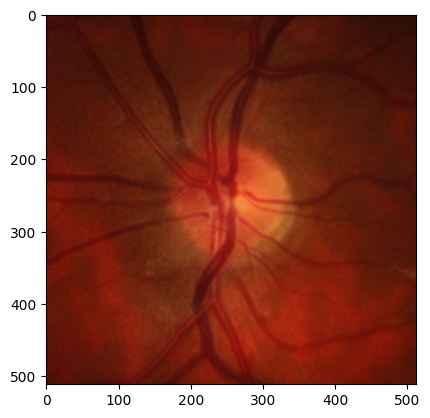

IMG: ['N-87-L.png'] CUP_DICE: [0.51214182] DISC_DICE: 0.8985305031913314
View img shape: (3, 512, 512)
Entropy map shape: torch.Size([1, 512, 512])
uint8
float32


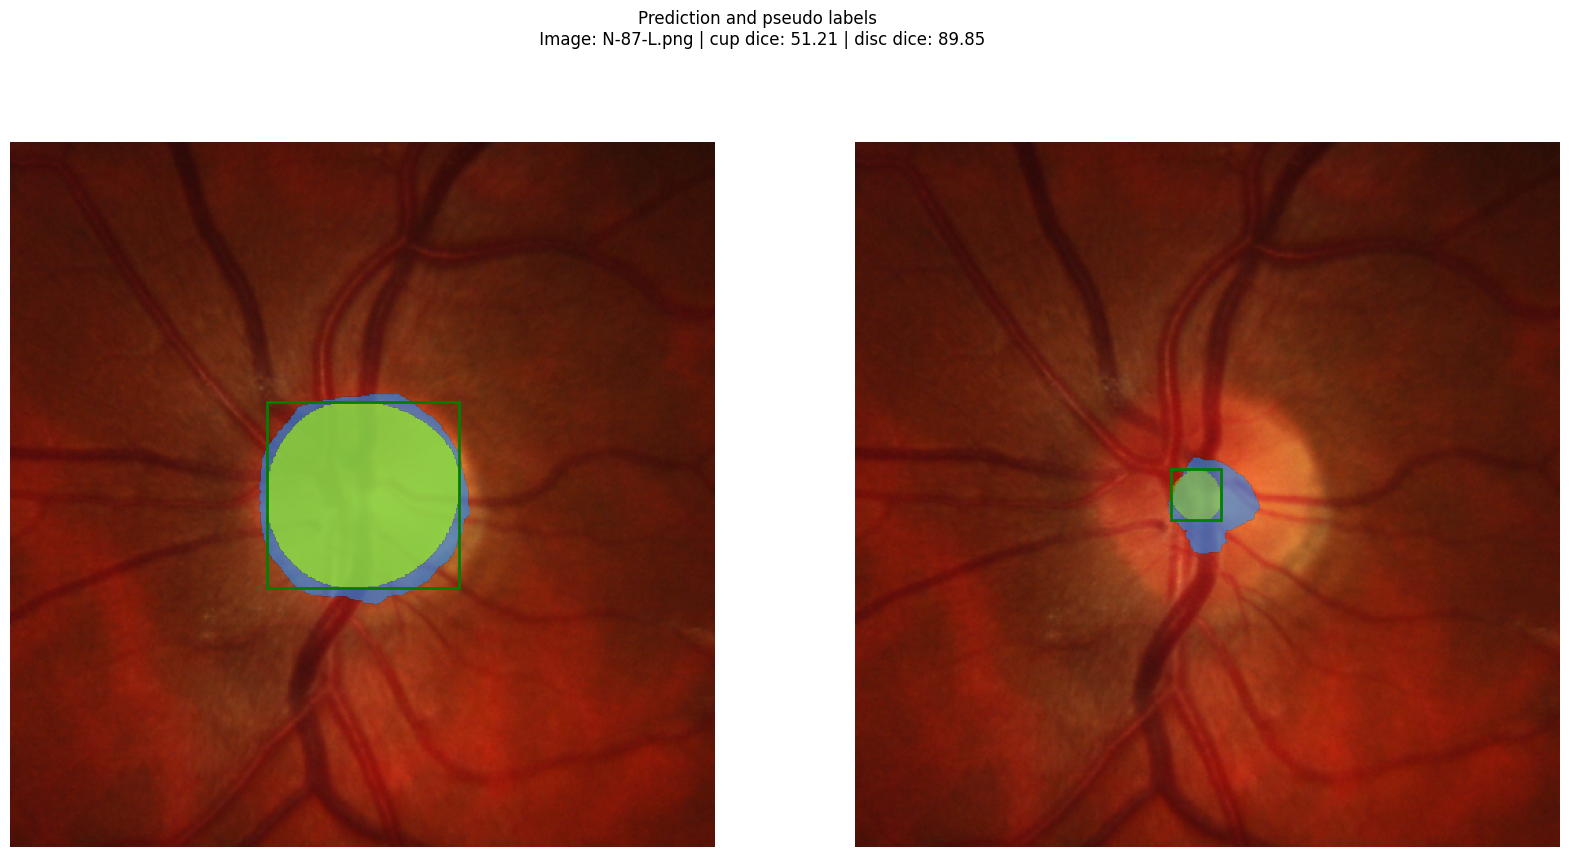

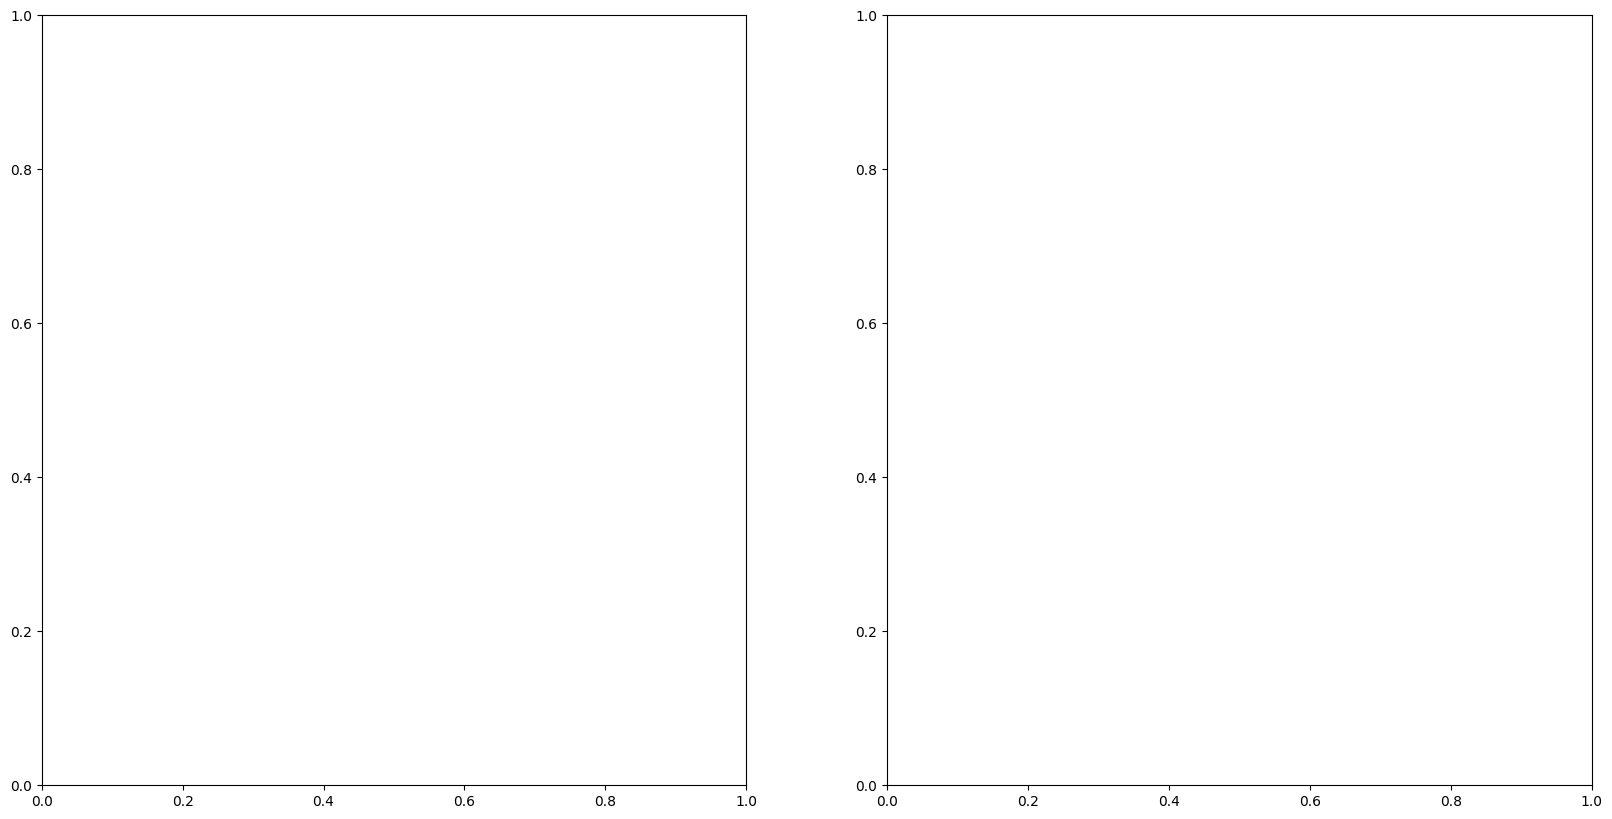

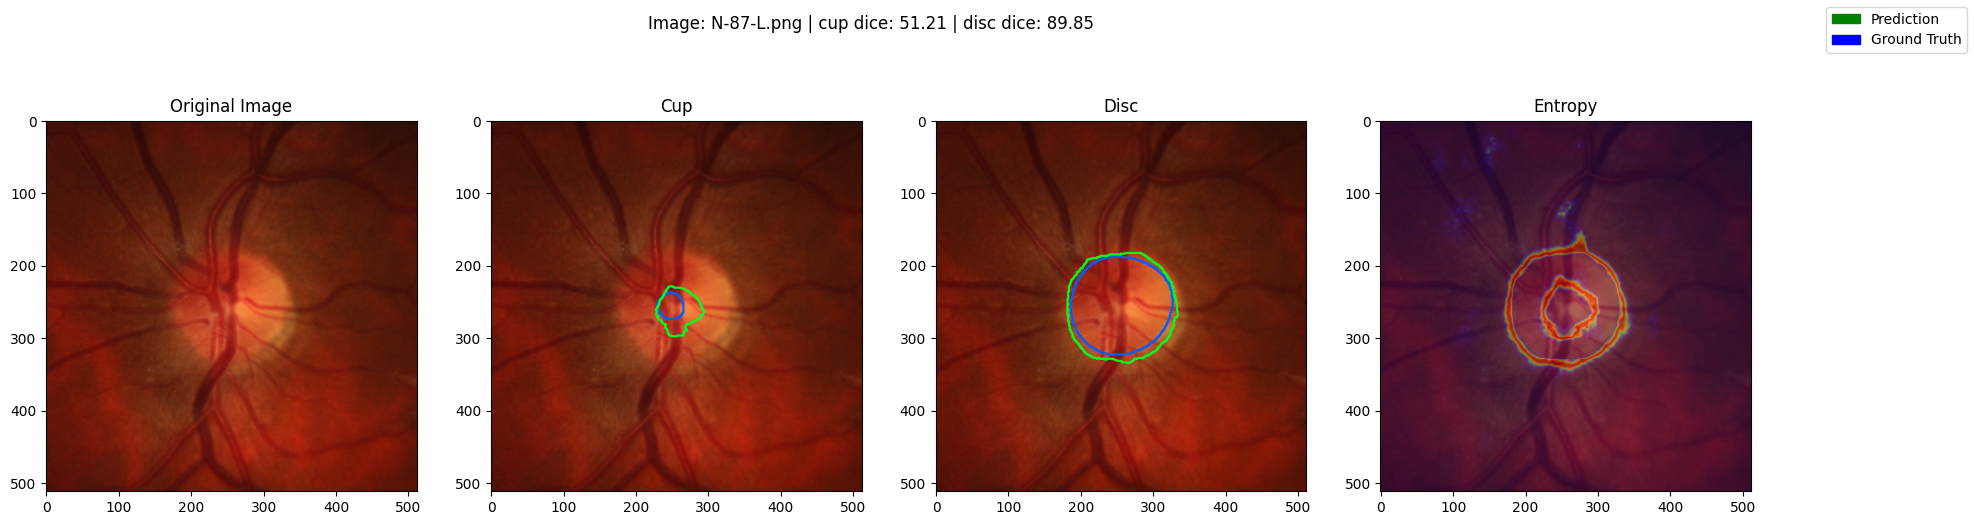

CUP DPL DICE  [0.86890708] disc DPL DICE  [0.92385886]


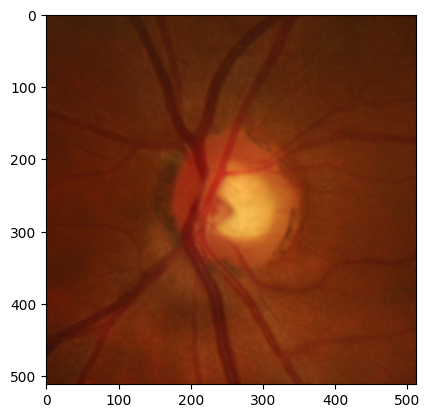

IMG: ['S-20-L.png'] CUP_DICE: [0.86890708] DISC_DICE: 0.9238588582079847
View img shape: (3, 512, 512)
Entropy map shape: torch.Size([1, 512, 512])
uint8
float32


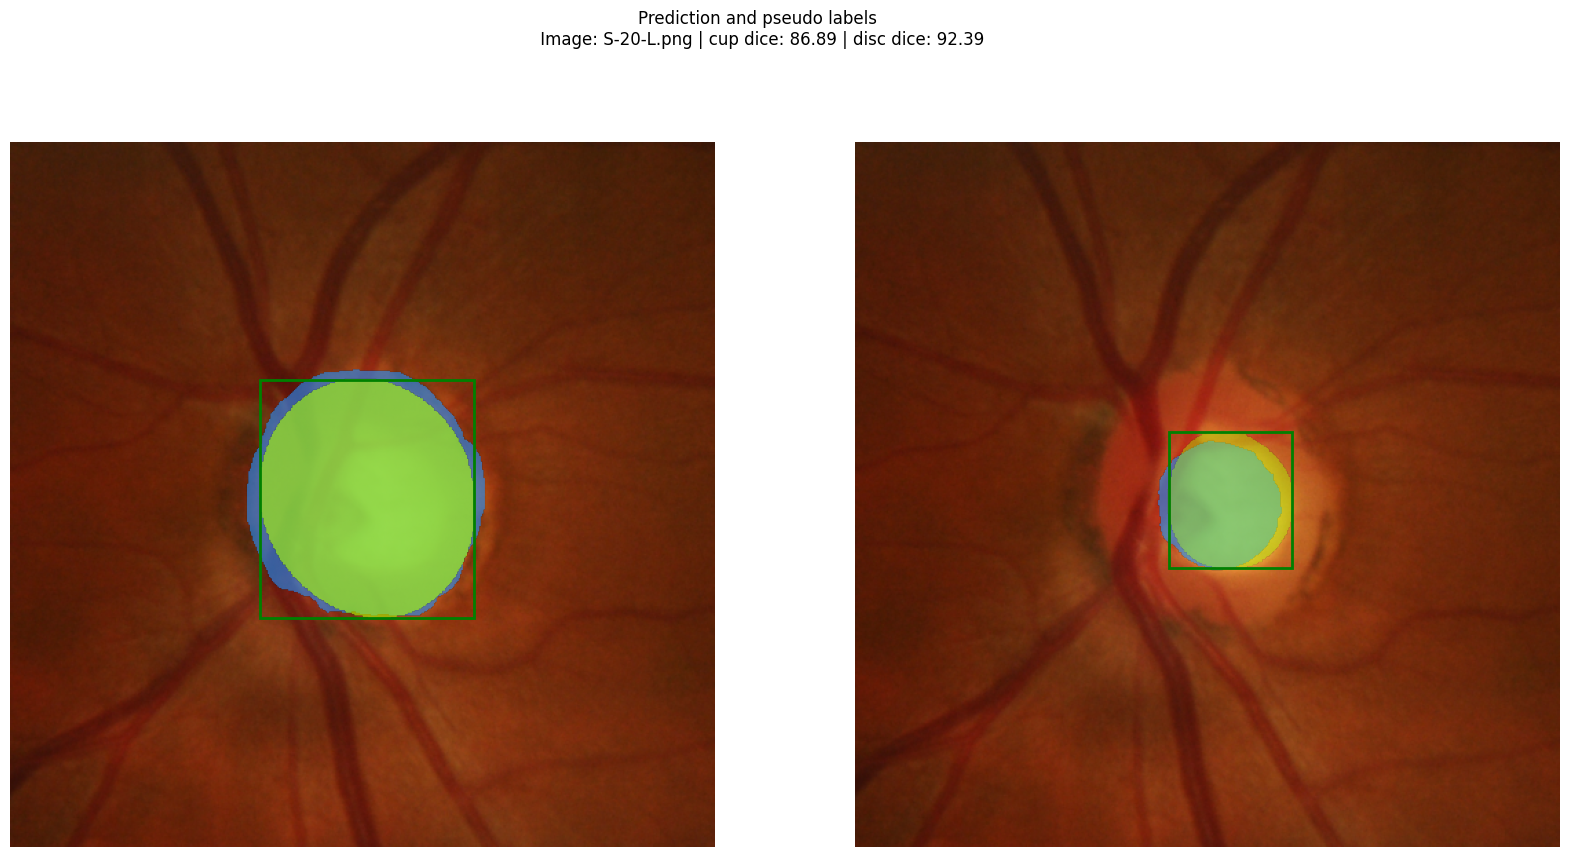

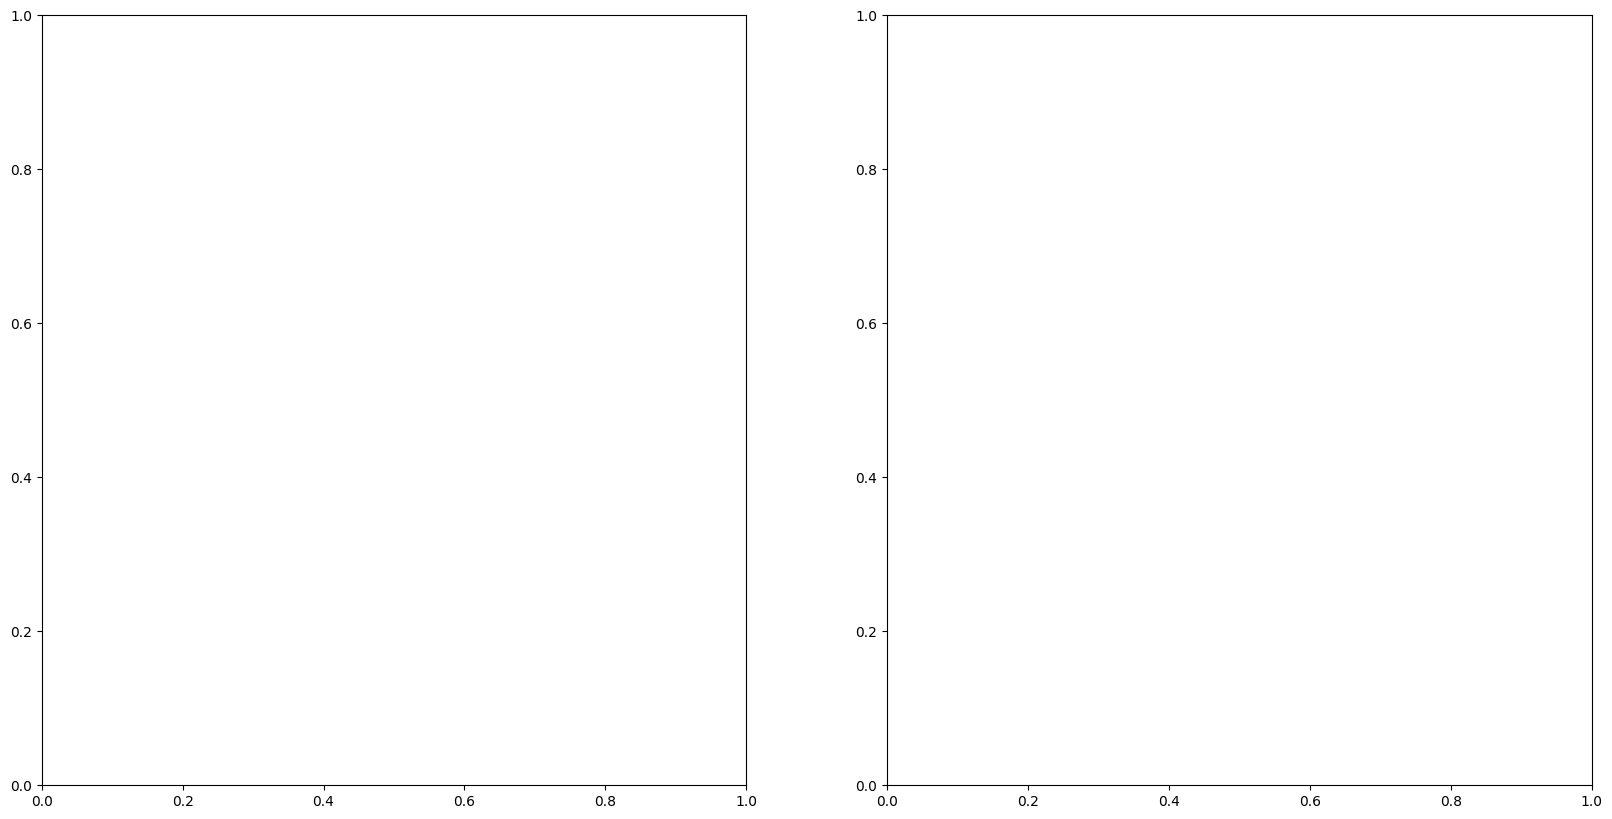

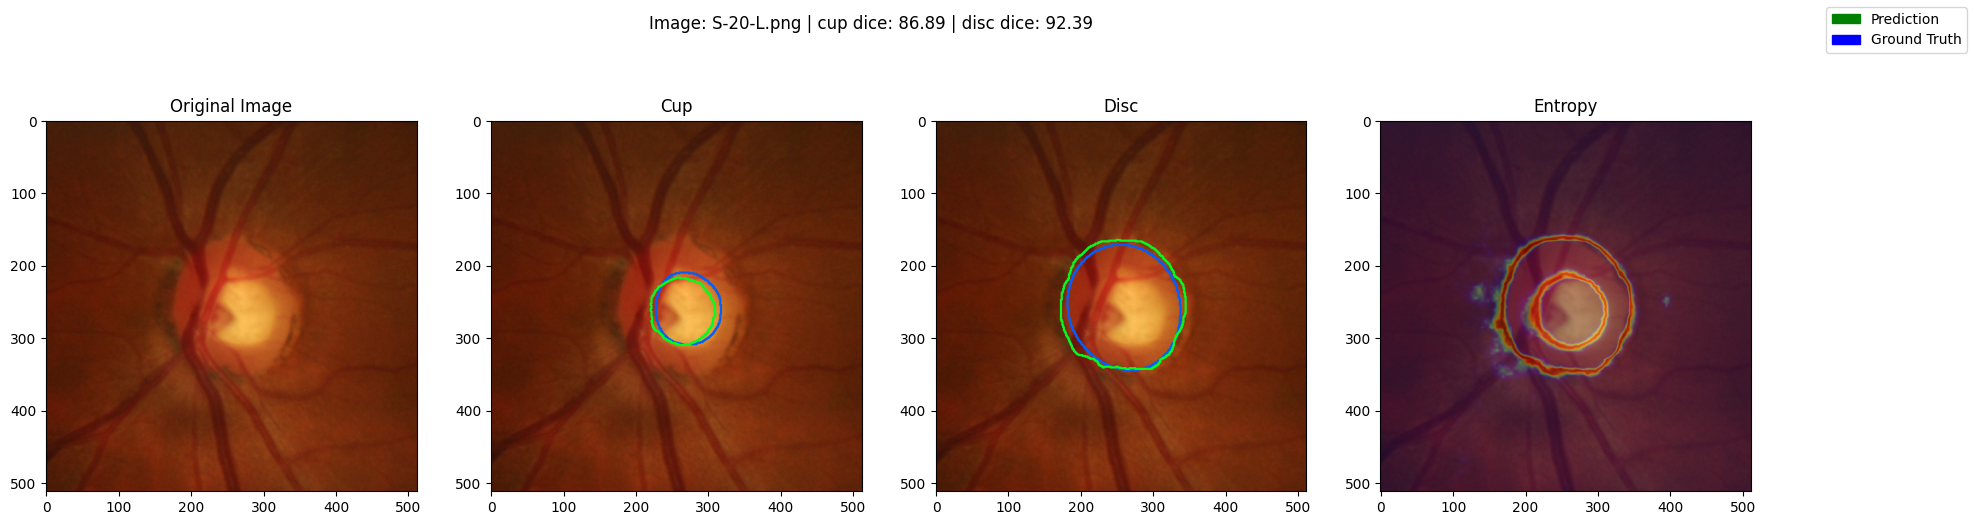

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])


In [17]:
# print(np.__version__)
model.train()
show_vis = True
get_hd = True
val_cup_dice = 0.0;val_disc_dice = 0.0;datanum_cnt = 0.0
val_sam_cup_dice = 0.0;val_sam_disc_dice = 0.0
val_sam_cup_pseudo_dice = 0.0;val_sam_disc_pseudo_dice = 0.0
cup_hd = 0.0; disc_hd = 0.0;datanum_cnt_cup = 0.0;datanum_cnt_disc = 0.0
for idx, sample in enumerate(train_loader):
    data, target, img_name = sample['image'], sample['map'], sample['img_name']
    if not ('S-20' in img_name[0] or 'N-87' in img_name[0]):
        continue
    # if img_name[0] != 'N-90-R.png':
    #     continue
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    prediction, boundary, _ = model(data)
    prediction = torch.sigmoid(prediction)

    target_numpy = target.data.cpu()
    prediction = prediction.data.cpu()
    probs = prediction.clone()
    prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


    cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
    disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])

    entropy_map = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    
    # box 1 - disc, box 0 - cup
    pseudo_boxes = masks_to_boxes(denoised_pl[img_name[0]][0]).cpu()
    gt_boxes = masks_to_boxes(target_numpy[0])
    # print("BOX", boxes)
    
    boxes = gt_boxes
    
    view_img = make_grid(
                    data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
    view_img = view_img.transpose(1,2,0)

    print("CUP DPL DICE ", cup_dice , "disc DPL DICE ", disc_dice)
    
    for i in range(prediction.shape[0]):
        hd_tmp = hd_numpy(prediction[i, 0, ...], target_numpy[i, 0, ...], get_hd)
        if np.isnan(hd_tmp):
            datanum_cnt_cup -= 1.0
        else:
            cup_hd += hd_tmp

        hd_tmp = hd_numpy(prediction[i, 1, ...], target_numpy[i, 1, ...], get_hd)
        if np.isnan(hd_tmp):
            datanum_cnt_disc -= 1.0
        else:
            disc_hd += hd_tmp

    val_cup_dice += np.sum(cup_dice)
    val_disc_dice += np.sum(disc_dice)

    datanum_cnt += float(prediction.shape[0])
    datanum_cnt_cup += float(prediction.shape[0])
    datanum_cnt_disc += float(prediction.shape[0])
    
    # cup_pseudo = pseudo_label_dic[img_name[0]][0]
    # disc_pseudo = pseudo_label_dic[img_name[0]][1]
    
    cup_pseudo = denoised_pl[img_name[0]][0][0].cpu()
    disc_pseudo = denoised_pl[img_name[0]][0][1].cpu()

    if show_vis or idx % 10 == 0:
        plt.figure()
        plt.imshow(view_img)
        plt.show()
        
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        classes_names = ['cup', 'disc']
        fig.suptitle(f"Prediction and pseudo labels \n Image: {img_name[0]} | {classes_names[0]} dice: {round(cup_dice[0], 4) * 100} | {classes_names[1]} dice: {round(disc_dice[0], 4) * 100}")
        
        axes[0].imshow(view_img)
        show_mask(prediction[0][1], axes[0])
        show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True)
        show_box(boxes[1], axes[0])
        axes[0].axis('off')
        # axes[0].show()

        # plt.imshow(view_img)
        axes[1].imshow(view_img)
        show_mask(prediction[0][0], axes[1])
        show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        show_box(boxes[0], axes[1])
        axes[1].axis('off')
        
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        
        # axes[0].imshow(view_img)
        # show_mask(disc_pseudo, axes[0])
        # show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True, alpha=0.4)
        # show_box(boxes[1], axes[0])
        # show_box(pseudo_boxes[1], axes[0])
        # axes[0].axis('off')
        
        # axes[1].imshow(view_img)
        # show_mask(cup_pseudo, axes[1])
        # show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        # show_box(boxes[0], axes[1])
        # show_box(pseudo_boxes[0], axes[1])
        # axes[1].axis('off')
        
        create_visuals({}, data, target, img_name, prediction, target_numpy, cup_dice, disc_dice, entropy_map)
        plt.show()

print(data.shape)
print(target.shape)


In [18]:
val_cup_dice_new = val_cup_dice / datanum_cnt
val_disc_dice_new = val_disc_dice / datanum_cnt
cup_hd_new = cup_hd / datanum_cnt_cup
disc_hd_new = disc_hd / datanum_cnt_disc

print("(DPL) cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f" %
(val_cup_dice_new, val_disc_dice_new, (val_cup_dice_new+val_disc_dice_new)/2.0, cup_hd_new, disc_hd_new, (cup_hd_new+disc_hd_new)/2.0))

(DPL) cup: 0.6905 disc: 0.9112 avg: 0.8009 cup: 8.7764 disc: 6.6693 avg: 7.7229


This one compares SAM output with pseudo and GT, computes the dice score for both settings and the no-ada one as well.

In [35]:
import math
pi = math.pi
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC


def PointsInCircum(r,n=100):
    if n == 0:
        return []
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

def PointsInElipse(r1, r2, n=100):
    
    ellipsePoints = [
    (r1 * math.cos(theta), r2 * math.sin(theta))
    for theta in (math.pi*2 * i/n for i in range(n))

    ]
    return ellipsePoints

def PointsInGrid(x0, y0, x1, y1, n=100):
    x = np.linspace(x0, x1, n)
    y = np.linspace(y0, y1, n)
    xx, yy = np.meshgrid(x, y)
    return np.array(list(zip(xx.flatten(), yy.flatten())))

def CreateMaskNumpyFromRadiusAndCenter(center, radius, shape):
    mask = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if (i - center[0])**2 + (j - center[1])**2 < radius**2:
                mask[i, j] = 1
    return mask

def GetClosestPoint(points, point, num = 1, fix_multi=1, max_distance=100000):
    dis_array = np.sqrt(np.sum((points-point)**2, axis=1, keepdims=True))
    # .argmin(axis=0)
    print("shape of array", dis_array.shape)
    rel_idx = np.nonzero(dis_array < max_distance, )
    num_relevant = len(rel_idx[0])
    print(f"num_relevant: {num_relevant}")
    # print(f"{rel_idx}")
    
    relevant_skips = int(num_relevant / num )
    print(f"relevant_skips: {relevant_skips}")
    
    # num_multiplied = int(num // fix_multi)
    # print(num_multiplied)
    # skips = 1 // fix_multi
    
    indices = np.argpartition(dis_array, num_relevant, axis=0)[:num_relevant]
    print(max_distance)
    chosen_indices = [p for p in indices if p%relevant_skips == 0 and dis_array[p] < max_distance]
    print("Returning {} points".format(len(chosen_indices)))
    return chosen_indices

# def GetClosestPoint(points, point):
#     min_dist = 100000000
#     closest_point = None
#     for p in points:
#         dist = np.linalg.norm(np.array(p) - np.array(point))
#         if dist < min_dist:
#             min_dist = dist
#             closest_point = p
#     return closest_point


def get_points_from_boxes(boxes, n, n_cup = 0, radius_ratio=0.75, radius_ratio_cup = 0.75, sam_neg=-1, inner_cup = True, inner_disc = True):
    inside_circle_ratio = radius_ratio
    size_cup = boxes[0][2] - boxes[0][0]
    size_disc = boxes[1][2] - boxes[1][0]
    size_cup_y = boxes[0][3] - boxes[0][1]
    size_disc_y = boxes[1][3] - boxes[1][1]
    
    cup_disc_x_diff = ((boxes[0][0] - boxes[1][0]) + (boxes[1][2] - boxes[0][2]))/2
    cup_disc_y_diff = ((boxes[0][1] - boxes[1][1]) + (boxes[1][3] - boxes[0][3]))/2
    buffer_x = cup_disc_x_diff * 0.25
    buffer_y = cup_disc_y_diff * 0.25
    
    cup_disc_x_diff = ((boxes[0][0] - boxes[1][0]) + (boxes[1][2] - boxes[0][2]))/2
    cup_disc_y_diff = ((boxes[0][1] - boxes[1][1]) + (boxes[1][3] - boxes[0][3]))/2
    
    # boxes[0][0] -= cup_disc_x_diff/2
    # boxes[0][2] += cup_disc_x_diff/2
    # boxes[0][1] -= cup_disc_y_diff/2
    # boxes[0][3] += cup_disc_y_diff/2
    
    points_cup = PointsInElipse(r2 = (size_cup_y * radius_ratio_cup) * 0.5 ,r1 = (size_cup * radius_ratio_cup) * 0.5 , n=n_cup)
    points_cup_inner = PointsInElipse(r2 = (size_cup_y * radius_ratio_cup) * 0.25 ,r1 = (size_cup * radius_ratio_cup) * 0.25 , n=n_cup//2)
    points_disc = PointsInElipse(r2 = (size_disc_y * inside_circle_ratio) * 0.5 ,r1 = (size_disc * inside_circle_ratio) * 0.5 , n=n)
    points_disc_inner = PointsInElipse(r2 = (size_disc_y * inside_circle_ratio) * 0.25 ,r1 = (size_disc * inside_circle_ratio) * 0.25 , n=n//2)
    # points_cup = PointsInCircum(r = (size_cup * radius_ratio_cup) * 0.5 , n=n)
    # points_cup_inner = PointsInCircum(r = (size_cup * radius_ratio_cup) * 0.25 , n=n)
    # points_disc = PointsInCircum(r = (size_disc * inside_circle_ratio) * 0.5 , n=n)
    
    middle_cup = (boxes[0][0] + size_cup / 2, boxes[0][1] + size_cup_y / 2)
    middle_disc = (boxes[1][0] + size_disc / 2, boxes[1][1] + size_disc_y / 2)
    
    
    points_cup  = np.array([(int(p[0] + middle_cup[0]) , int(p[1] + middle_cup[1])) for p in points_cup])    
    points_cup_inner  = np.array([(int(p[0] + middle_cup[0]) , int(p[1] + middle_cup[1])) for p in points_cup_inner])
    points_disc_inner  = np.array([(int(p[0] + middle_disc[0]) , int(p[1] + middle_disc[1])) for p in points_disc_inner])
    points_disc  = np.array([(int(p[0] + middle_disc[0]) , int(p[1] + middle_disc[1])) for p in points_disc])
    labels_cup = [1 for _ in points_cup]
    labels_disc = [1 for _ in points_disc]
    if inner_cup:
        labels_cup.extend([1 for _ in points_cup_inner])
        points_cup = np.concatenate((points_cup, points_cup_inner), axis=0)
    if inner_disc:
        labels_disc.extend([1 for _ in points_disc_inner])
        points_disc = np.concatenate((points_disc, points_disc_inner), axis=0)
    
    if sam_neg > 0:
        # points_cup_neg = PointsInCircum(r = ((size_cup/2 + ((cup_disc_x_diff + cup_disc_y_diff) * 1/2)) ) * 0.465 , n=sam_neg)
        points_cup_neg = PointsInElipse(r2 = (0.5 * size_cup_y) + buffer_y , r1 = size_cup * 0.5 + buffer_x , n=sam_neg)
        # points_cup_neg.extend(PointsInCircum(r = ((size_cup + ((cup_disc_x_diff + cup_disc_y_diff)/2))) * 0.5 , n=sam_neg))
        points_cup_neg  = np.array([(int(p[0] + middle_cup[0]) , int(p[1] + middle_cup[1])) for p in points_cup_neg])
        
        if len(points_cup) > 0:
            all_cup = np.concatenate((points_cup, points_cup_neg), axis=0)
        else: 
            all_cup = points_cup_neg
        print("ALLCUP SHAPEEEEE", all_cup.shape)
        print("ALLdisc SHAPEEEEE", points_disc.shape)
        labels_cup_neg = [0 for _ in points_cup_neg]
        labels_cup.extend(labels_cup_neg)
    else: 
        all_cup = points_cup
    
    labels_cup = np.array(labels_cup)
    labels_disc = np.array([1 for _ in points_disc])
    return all_cup, points_disc, labels_cup, labels_disc

def enlarge_boxes(boxes):
    boxes[0][0] = int(boxes[0][0] * 0.9)
    boxes[0][1] = int(boxes[0][1] * 0.9)
    boxes[0][2] = int(boxes[0][0] * 1.1)
    boxes[0][3] = int(boxes[0][1] * 1.1)
    
    boxes[1][0] = int(boxes[0][0] * 0.7)
    boxes[1][1] = int(boxes[0][1] * 0.7)
    boxes[1][2] = int(boxes[0][0] * 1.3)
    boxes[1][3] = int(boxes[0][1] * 1.3)
    
    return boxes
    

In [68]:
# print(np.__version__)
pseudo_label_dic_sam = {}
sam_points = 14
sam_fix_points = 8
fix_multi = 0.08
max_dis = 0.5

sam_points_cup = 8
sam_neg = 0
sam_buffer = 0
sam_radius_ratio = 0.75
sam_radius_ratio_cup = 0.65
enable_inner_cup = False
enable_inner_disc = True
show_vis = False
get_hd = True
val_cup_dice = 0.0;val_disc_dice = 0.0;datanum_cnt = 0.0
val_sam_cup_dice = 0.0;val_sam_disc_dice = 0.0
val_sam_cup_pseudo_dice = 0.0;val_sam_disc_pseudo_dice = 0.0
val_saminter_cup_dice = 0; val_samplus_cup_dice = 0
val_saminter_disc_dice = 0; val_sam_disc_fix_dice = 0; val_saminter_disc_fix_dice = 0
cup_hd = 0.0; disc_hd = 0.0;datanum_cnt_cup = 0.0;datanum_cnt_disc = 0.0

for idx, sample in enumerate(test_loader):
    # if idx > 10:
    #     break
    data, target, img_name = sample['image'], sample['map'], sample['img_name']
    # if 'ndrishtiGS_072' not in img_name[0]:
    #     continue
    # if not ('N-87' in img_name[0] or 'N-87' in img_name[0]):
    #     continue
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    prediction, boundary, _ = model(data)
    prediction = torch.sigmoid(prediction)

    target_numpy = target.data.cpu()
    prediction = prediction.data.cpu()
    probs = prediction.clone()
    prediction[prediction>0.75] = 1;prediction[prediction <= 0.75] = 0


    cup_dice = dice_coefficient_numpy(prediction[:,0, ...], target_numpy[:, 0, ...])
    disc_dice = dice_coefficient_numpy(prediction[:,1, ...], target_numpy[:, 1, ...])

    # print("cup_dice: ", cup_dice)
    # print("disc_dice: ", disc_dice)
    # print(cup_dice)
    # print("Probs: ", probs.shape)
    entropy_map = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    # print(prediction.shape)
    # box 1 - disc, box 0 - cup
    # print(torch.from_numpy(pseudo_label_dic[img_name[0]]))
    # print(target_numpy[0].shape)
    try:
        pseudo_boxes = masks_to_boxes(denoised_pl[img_name[0]][0]).cpu()
    except BaseException as err:
        print(err)
        print(f"ERROR! {img_name} failed")
    gt_boxes = masks_to_boxes(target_numpy[0])
    # print("BOX", boxes)
    
    boxes = gt_boxes
    
    view_img = make_grid(
                    data[0, ...].clone().cpu().data, 1, normalize=True).detach().cpu().numpy()
    view_img = view_img.transpose(1,2,0)
    predictor.set_image(view_img)
    

    points_disc = None
    labels_disc = None
    
    # gt_boxes = enlarge_boxes(gt_boxes)
    points_cup, points_disc, labels_cup, labels_disc, = get_points_from_boxes(gt_boxes, n=sam_points, n_cup = sam_points_cup, radius_ratio=sam_radius_ratio, radius_ratio_cup=sam_radius_ratio_cup ,sam_neg = sam_neg, inner_cup = enable_inner_cup, inner_disc = enable_inner_disc)
    points_cup_ps, points_disc_ps, labels_cup_ps, input_labels_ps, = get_points_from_boxes(pseudo_boxes, n=sam_points, n_cup = sam_points_cup, radius_ratio=sam_radius_ratio, radius_ratio_cup=sam_radius_ratio_cup ,sam_neg = sam_neg, inner_cup = enable_inner_cup, inner_disc = enable_inner_disc)
    
    # added_points = PointsInGrid(220,180,260,220, n=3)
    # points_disc = np.concatenate([points_disc, 
    #                              added_points])
    # labels_disc = np.concatenate([labels_disc, np.array([1 for _ in range(added_points.shape[0])])])
    
    # points_cup, points_disc, labels_cup, input_labels = points_cup_ps, points_disc_ps, labels_cup_ps, input_labels_ps
    # print("POINTS ON DISC", points_disc)
    # points_disc = points_disc
    labels_disc = np.array([1 for p in points_disc])
    # points_disc = PointsInCircum(r = size_disc, n=8)
    # points_cup  = [(p[0] + , p[1])]
    
    dice_masks, cup_masks = get_sam_on_boxes(view_img, predictor, boxes, points=points_disc, labels=labels_disc, points_cup=points_cup, labels_cup = labels_cup, box_buffer=sam_buffer)
    # dice_masks_pseudo, cup_masks_pseudo = get_sam_on_boxes(view_img, predictor, pseudo_boxes, points=points_disc_ps, labels=input_labels_ps,points_cup=points_cup_ps, labels_cup = labels_cup_ps, box_buffer=sam_buffer)
    dice_masks_pseudo, cup_masks_pseudo = dice_masks, cup_masks

    points_disc_v1 = points_disc.copy()
    labels_disc_v1 = labels_disc.copy()
    
    # import cv2 
    # cnts, _ = cv2.findContours(dice_masks[0].astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # print("num contours", len(cnts))
    # cnt = max(cnts, key=cv2.contourArea)
    # print("contour area", cv2.contourArea(cnt))
    # print("contour", len(cnt))
    
    # points_cv2 = np.where((getLargestCC(dice_masks[0])))
    # stacked_points_cv2 = np.stack(points_cv2, axis=-1)
    # print(stacked_points_cv2.shape)
    # enclosing_circle_disc = cv2.minEnclosingCircle(stacked_points_cv2)
    # size_disc = boxes[1][2] - boxes[1][0]
    # size_disc_y = boxes[1][3] - boxes[1][1]
    # middle_disc = (boxes[1][1] + size_disc_y / 2, boxes[1][0] + size_disc / 2,)
    # enclosing_mask = CreateMaskNumpyFromRadiusAndCenter(middle_disc, enclosing_circle_disc[1], dice_masks[0].shape)
    # missing_part = enclosing_mask * (prediction[0,1, ...].cpu().numpy() * (1 - dice_masks[0]))
    # points_missing = np.stack(np.where(missing_part), axis=-1)
    # point_to_add_idx = GetClosestPoint(points_missing, enclosing_circle_disc[0], num=sam_fix_points, fix_multi=fix_multi, max_distance = max_dis * enclosing_circle_disc[1])
    # if len(point_to_add_idx) > 0:
    #     adding_points = points_missing[point_to_add_idx][:,0,:]
    #     adding_points_fixed = np.array([[p[1],p[0]] for p in adding_points])
    #     points_disc = np.concatenate([points_disc, adding_points_fixed])
    #     labels_disc = np.concatenate([labels_disc, np.array([1 for _ in range(adding_points.shape[0])])])

    # dice_masks_fix, cup_masks_fix = get_sam_on_boxes(view_img, predictor, boxes, points=points_disc, labels=labels_disc, points_cup=points_cup, labels_cup = labels_cup, box_buffer=sam_buffer)
    dice_masks_fix, cup_masks_fix = dice_masks, cup_masks
    

    dice_sam_cup = dice_coefficient_numpy( cup_masks, target_numpy[:, 0, ...])
    dice_sam_disc = dice_coefficient_numpy( dice_masks, target_numpy[:, 1, ...])
    
    dice_sam_disc_fix = dice_coefficient_numpy( dice_masks_fix, target_numpy[:, 1, ...])
    
    dice_sam_pseudo_cup = dice_coefficient_numpy( cup_masks_pseudo, target_numpy[:, 0, ...])
    dice_sam_pseudo_disc = dice_coefficient_numpy( dice_masks_pseudo, target_numpy[:, 1, ...])
    
    sam_plus_pseudo = np.maximum(cup_masks , prediction[:,0, ...].cpu().numpy())
    sam_inter_pseudo = cup_masks * prediction[:,0, ...].cpu().numpy()
    ## denoised_pl[img_name[0]][0][0].cpu().numpy()    
    ## prediction[:,0, ...]
    sam_inter_pseudo_disc = dice_masks * prediction[:,1, ...].cpu().numpy()
    sam_inter_pseudo_disc_fix = dice_masks_fix * prediction[:,1, ...].cpu().numpy()
    ## denoised_pl[img_name[0]][0][1].cpu().numpy()
    ## prediction[:,1, ...]
    
    dice_samplus_cup = dice_coefficient_numpy( sam_plus_pseudo, target_numpy[:, 0, ...])
    dice_saminter_cup = dice_coefficient_numpy( sam_inter_pseudo, target_numpy[:, 0, ...])
    dice_saminter_disc = dice_coefficient_numpy( sam_inter_pseudo_disc, target_numpy[:, 1, ...])
    dice_saminter_disc_fix = dice_coefficient_numpy( sam_inter_pseudo_disc_fix, target_numpy[:, 1, ...])

    print("CUP DPL DICE ", cup_dice , "disc DPL DICE ", disc_dice)
    print("CUP SAM DICE ", dice_sam_cup, "disc SAM DICE ", dice_sam_disc)
    print("CUP SAM DICE PSEUDO", dice_sam_pseudo_cup, "disc SAM DICE PSEUDO", dice_sam_pseudo_disc)
    print("CUP SAM_INTER DICE ", dice_saminter_cup)
    print("CUP SAM_PLUS DICE ", dice_samplus_cup)
    print("CUP SAM_INTER DICE ", dice_saminter_cup)
    print("DISC SAM_INTER DICE ", dice_saminter_disc)
    print("DISC FIX SAM_INTER DICE ", dice_saminter_disc_fix)
    
    for i in range(prediction.shape[0]):
        hd_tmp = hd_numpy(prediction[i, 0, ...], target_numpy[i, 0, ...], get_hd)
        if np.isnan(hd_tmp):
            datanum_cnt_cup -= 1.0
        else:
            cup_hd += hd_tmp

        hd_tmp = hd_numpy(prediction[i, 1, ...], target_numpy[i, 1, ...], get_hd)
        if np.isnan(hd_tmp):
            datanum_cnt_disc -= 1.0
        else:
            disc_hd += hd_tmp

    val_cup_dice += np.sum(cup_dice)
    val_disc_dice += np.sum(disc_dice)
    val_sam_cup_dice += np.sum(dice_sam_cup)
    val_sam_disc_dice += np.sum(dice_sam_disc)
    val_sam_disc_fix_dice += np.sum(dice_sam_disc_fix)
    val_saminter_disc_fix_dice += np.sum(dice_saminter_disc_fix)
    val_sam_cup_pseudo_dice += np.sum(dice_sam_pseudo_cup)
    val_sam_disc_pseudo_dice += np.sum(dice_sam_pseudo_disc)
    val_samplus_cup_dice += np.sum(dice_samplus_cup)
    val_saminter_cup_dice += np.sum(dice_saminter_cup)
    val_saminter_disc_dice += np.sum(dice_saminter_disc)

    datanum_cnt += float(prediction.shape[0])
    datanum_cnt_cup += float(prediction.shape[0])
    datanum_cnt_disc += float(prediction.shape[0])
    
    # cup_pseudo = denoised_pl[img_name[0]][0][0].cpu()
    # disc_pseudo = denoised_pl[img_name[0]][0][1].cpu()
    
    pseudo_label_dic_sam[img_name[0]] = np.concatenate([sam_inter_pseudo,sam_inter_pseudo_disc])
    print("SHAPEEEEEEEEEEEEE same ok ?", pseudo_label_dic_sam[img_name[0]].shape)
    # print(pseudo_label_dic[img_name[0]].shape)

    if show_vis:
        print(f"################################### {img_name[0]} ###################################")
        
        plt.figure()
        plt.imshow(view_img)
        plt.show()
        
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle(f"(SAM GT) Image: {img_name[0]} | {classes_names[0]} dice: {round(dice_sam_cup[0], 4) * 100} | {classes_names[1]} dice: {round(dice_sam_disc[0], 4) * 100} {round(dice_sam_disc_fix[0], 4) * 100}")
        classes_names = ['cup', 'disc']
        
        # axes[0].imshow(view_img)
        # show_mask(dice_masks[0], axes[0])
        # show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True)
        # show_box(boxes[1], axes[0])
        # if input_points is not None:
        #     show_points(input_points, input_labels, axes[0])

        # axes[0].axis('off')
        # axes[0].show()

        plt.imshow(view_img)
        axes[0].imshow(view_img)
        show_mask(dice_masks[0], axes[0])
        # show_mask(dice_masks_fix[0] * (1-dice_masks[0]) , axes[0], random_color=True)
        # show_mask((dice_masks[0]), axes[0])
        # show_mask(missing_part,axes[0])
        # show_mask(enclosing_mask,axes[0])
        show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True, alpha=0.4)
        show_box(boxes[1], axes[0])
        if points_disc is not None and len(points_disc) > 0:
            show_points(points_disc, labels_disc, axes[0])
        # axes[0].axis('off')
        
        # axes[1].imshow(view_img)
        # show_mask(dice_masks[0], axes[1])
        # # show_mask(dice_masks_fix[0] * (1-dice_masks[0]) , axes[0], random_color=True)
        # # show_mask((dice_masks[0]), axes[0])
        # # show_mask(missing_part,axes[0])
        # # show_mask(enclosing_mask,axes[0])
        # show_mask(target[0][1].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        # show_box(boxes[1], axes[1])
        # if points_disc is not None and len(points_disc) > 0:
        #     show_points(points_disc_v1, labels_disc_v1, axes[1])
        # axes[0].axis('off')
        
        axes[1].imshow(view_img)
        show_mask(cup_masks[0], axes[1])
        show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True)
        show_box(boxes[0], axes[1])
        if points_cup is not None and len(points_cup) > 0:
            show_points(points_cup, labels_cup, axes[1])
                
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle(f"(SAM INTER) Image: {img_name[0]} | {classes_names[0]} dice: {round(dice_saminter_cup[0], 4) * 100} | {classes_names[1]} dice: {round(dice_saminter_disc[0], 4) * 100}")
        
        axes[0].imshow(view_img)
        show_mask(sam_inter_pseudo_disc[0], axes[0])
        show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True)
        # show_box(pseudo_boxes[1], axes[0])
        if points_disc_ps is not None and len(points_disc_ps) > 0:
            # show_points(points_disc_ps, input_labels_ps, axes[0])
            show_points(points_disc, labels_disc, axes[0])

        # axes[0].axis('off')
        # axes[0].show()

        # plt.imshow(view_img)
        axes[1].imshow(view_img)
        show_mask(sam_inter_pseudo[0], axes[1])
        show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        # show_box(pseudo_boxes[0], axes[1])
        if points_cup_ps is not None and len(points_cup_ps) > 0:
            # show_points(points_cup_ps, labels_cup_ps, axes[1])
            show_points(points_cup, labels_cup, axes[1])

        # axes[1].axis('off')
        
        # fig,axes = plt.subplots(1,2,figsize=(20,10))
        # fig.suptitle(f"Image: {img_name[0]} | Pseudo labels from dict")
        
        # axes[0].imshow(view_img)
        # # show_mask(disc_pseudo * (1-dice_masks), axes[0])
        # show_mask(disc_pseudo , axes[0])
        # show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True, alpha=0.4)
        # show_box(boxes[1], axes[0])
        # show_box(pseudo_boxes[1], axes[0])
        # # axes[0].axis('off')
        
        # axes[1].imshow(view_img)
        # show_mask(cup_pseudo, axes[1])
        # show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        # show_box(boxes[0], axes[1])
        # show_box(pseudo_boxes[0], axes[1])
        # # axes[1].axis('off')
        
        fig,axes = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle(f"Image: {img_name[0]} | Model's prediction (After DPL)")
        
        axes[0].imshow(view_img)
        # show_mask(disc_pseudo * (1-dice_masks), axes[0])
        show_mask(prediction[:,1, ...] , axes[0])
        show_mask(target[0][1].cpu().numpy(), axes[0], gt_color=True, alpha=0.4)
        show_box(boxes[1], axes[0])
        show_box(pseudo_boxes[1], axes[0])
        # axes[0].axis('off')
        
        axes[1].imshow(view_img)
        show_mask(prediction[:,0, ...], axes[1])
        show_mask(target[0][0].cpu().numpy(), axes[1], gt_color=True, alpha=0.4)
        show_box(boxes[0], axes[1])
        show_box(pseudo_boxes[0], axes[1])
        # axes[1].axis('off')
    
        # create_visuals({}, data, target, img_name, prediction, target_numpy, cup_dice, disc_dice, entropy_map)        
        plt.show()


print(data.shape)
print(target.shape)


'N-1-L.png'
ERROR! ['N-1-L.png'] failed
(1, 512, 512)
CUP DPL DICE  [0.67021152] disc DPL DICE  [0.87198849]
CUP SAM DICE  [0.79183816] disc SAM DICE  [0.90657987]
CUP SAM DICE PSEUDO [0.79183816] disc SAM DICE PSEUDO [0.90657987]
CUP SAM_INTER DICE  [0.80435091]
CUP SAM_PLUS DICE  [0.66154381]
CUP SAM_INTER DICE  [0.80435091]
DISC SAM_INTER DICE  [0.90890801]
DISC FIX SAM_INTER DICE  [0.90890801]
SHAPEEEEEEEEEEEEE same ok ? (2, 512, 512)
'N-36-R.png'
ERROR! ['N-36-R.png'] failed
(1, 512, 512)
CUP DPL DICE  [0.87486959] disc DPL DICE  [0.87934986]
CUP SAM DICE  [0.86126859] disc SAM DICE  [0.8824091]
CUP SAM DICE PSEUDO [0.86126859] disc SAM DICE PSEUDO [0.8824091]
CUP SAM_INTER DICE  [0.80952737]
CUP SAM_PLUS DICE  [0.91437165]
CUP SAM_INTER DICE  [0.80952737]
DISC SAM_INTER DICE  [0.90333579]
DISC FIX SAM_INTER DICE  [0.90333579]
SHAPEEEEEEEEEEEEE same ok ? (2, 512, 512)
'G-30-L.png'
ERROR! ['G-30-L.png'] failed
(1, 512, 512)
CUP DPL DICE  [0.85899755] disc DPL DICE  [0.8972656]
CUP 

In [69]:
val_cup_dice_new = val_cup_dice / datanum_cnt
val_disc_dice_new = val_disc_dice / datanum_cnt
cup_hd_new = cup_hd / datanum_cnt_cup
disc_hd_new = disc_hd / datanum_cnt_disc

print("(DPL) cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f" %
(val_cup_dice_new, val_disc_dice_new, (val_cup_dice_new+val_disc_dice_new)/2.0, cup_hd_new, disc_hd_new, (cup_hd_new+disc_hd_new)/2.0))

val_cup_dice_new_sam = val_sam_cup_dice / datanum_cnt
val_disc_dice_new_sam = val_sam_disc_dice / datanum_cnt
cup_hd_new_sam = cup_hd / datanum_cnt_cup
disc_hd_new_sam = disc_hd / datanum_cnt_disc

print("(SAM WITH GT BBOX) cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f, HD IS NOT UPDATED FOR SAM" %
(val_cup_dice_new_sam, val_disc_dice_new_sam, (val_cup_dice_new_sam+val_disc_dice_new_sam)/2.0, cup_hd_new_sam, disc_hd_new_sam, (cup_hd_new_sam+disc_hd_new_sam)/2.0))

val_cup_dice_new_sam_p = val_sam_cup_pseudo_dice / datanum_cnt
val_disc_dice_new_sam_p = val_sam_disc_pseudo_dice / datanum_cnt
cup_hd_new_sam = cup_hd / datanum_cnt_cup
disc_hd_new_sam = disc_hd / datanum_cnt_disc

print("(SAM WITH PSEUDO BBOX) cup: %.4f disc: %.4f avg: %.4f cup: %.4f disc: %.4f avg: %.4f, HD IS NOT UPDATED FOR SAM" %
(val_cup_dice_new_sam_p, val_disc_dice_new_sam_p, (val_cup_dice_new_sam_p+val_disc_dice_new_sam_p)/2.0, cup_hd_new_sam, disc_hd_new_sam, (cup_hd_new_sam+disc_hd_new_sam)/2.0))
# print("best cup: %.4f best disc: %.4f best avg: %.4f best cup: %.4f best disc: %.4f best avg: %.4f" %
# (best_val_cup_dice, best_val_disc_dice, best_avg, best_cup_hd, best_disc_hd, best_avg_hd))

val_cup_dice_inter = val_saminter_cup_dice / datanum_cnt
val_cup_dice_plus = val_samplus_cup_dice / datanum_cnt
val_disc_dice_inter = val_saminter_disc_dice / datanum_cnt
val_disc_fix_dice = val_sam_disc_fix_dice / datanum_cnt
val_disc_fix_dice_inter = val_saminter_disc_fix_dice / datanum_cnt


print("(SAM PLUS AND INTER) cup plus: %.4f cup inter: %.4f" %
(val_cup_dice_plus, val_cup_dice_inter))

print(f"DISC INTER: {val_disc_dice_inter}")
print(f"DICE FIX {val_disc_fix_dice}")
print(f"DICE FIX {val_disc_fix_dice_inter}")

# print("num of low dice: ", cnt_low_dice)
print("num of total images: ", datanum_cnt_cup)

#  When using the no-ada bounding boxes as labels:
# (DPL) cup: 0.7441 disc: 0.8320 avg: 0.7881 cup: 14.3889 disc: 23.7313 avg: 19.0601
# (SAM) cup: 0.5610 disc: 0.5892 avg: 0.5751 cup: 14.3889 disc: 23.7313 avg: 19.0601, HD IS NOT UPDATED FOR SAM



(DPL) cup: 0.7457 disc: 0.8327 avg: 0.7892 cup: 13.5854 disc: 23.5492 avg: 18.5673
(SAM WITH GT BBOX) cup: 0.8290 disc: 0.8850 avg: 0.8570 cup: 13.5854 disc: 23.5492 avg: 18.5673, HD IS NOT UPDATED FOR SAM
(SAM WITH PSEUDO BBOX) cup: 0.8290 disc: 0.8850 avg: 0.8570 cup: 13.5854 disc: 23.5492 avg: 18.5673, HD IS NOT UPDATED FOR SAM
(SAM PLUS AND INTER) cup plus: 0.7274 cup inter: 0.8524
DISC INTER: 0.8981150710033958
DICE FIX 0.8850132778997255
DICE FIX 0.8981150710033958
num of total images:  60.0


In [34]:
print(pseudo_label_dic_sam)
np.savez("./results/prototype/sam_improved_labels_v2", pseudo_label_dic_sam)

{'N-1-L.png': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32), 'N-36-R.png': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
 

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [ ]:
input_point = np.array([[300, 300]])
input_label = np.array([1])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[300, 375], [250, 235]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[100, 375], [125, 325]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([100, 300, 200, 375])

In [ ]:
predictor.set_image(image)

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
# input_box = np.array([0, 600, 700, 400])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
print("INPUT", input_box)
plt.axis('off')
plt.show()

In [ ]:
print(boxes)

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([180, 360, 180, 360])
input_point = np.array([[100, 300]])
input_label = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [ ]:
predictor.set_image(truck_image)

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, truck_image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()